In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.6 MB/s eta 0:00:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:


# Read data:
series = AirPassengersDataset().load()

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))



In [ ]:
series

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)> Size: 1kB
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1kB 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

#BTC

In [ ]:
!pip install pytorch_lightning
!pip install darts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.4 MB/s eta 0:00

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import TQDMProgressBar

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

import warnings

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.CRITICAL)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [ ]:
import yfinance as yf
from datetime import date, timedelta

today = date.today()
one_year_ago = today - timedelta(days=(365*5))

btc = yf.download("BTC-USD", start=one_year_ago, end=today)
print(btc.info())
btc

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2019-10-29 00:00:00+00:00 to 2024-10-26 00:00:00+00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, BTC-USD)  1825 non-null   float64
 1   (Close, BTC-USD)      1825 non-null   float64
 2   (High, BTC-USD)       1825 non-null   float64
 3   (Low, BTC-USD)        1825 non-null   float64
 4   (Open, BTC-USD)       1825 non-null   float64
 5   (Volume, BTC-USD)     1825 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 99.8 KB
None


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2019-10-29 00:00:00+00:00,9427.687500,9427.687500,9516.180664,9232.648438,9248.440430,28426779937
2019-10-30 00:00:00+00:00,9205.726562,9205.726562,9426.874023,9085.370117,9422.462891,27706531577
2019-10-31 00:00:00+00:00,9199.584961,9199.584961,9383.161133,9028.717773,9202.458008,26583653947
2019-11-01 00:00:00+00:00,9261.104492,9261.104492,9275.657227,9132.047852,9193.992188,24324691031
2019-11-02 00:00:00+00:00,9324.717773,9324.717773,9377.486328,9249.587891,9259.783203,21242676385
...,...,...,...,...,...,...
2024-10-22 00:00:00+00:00,67361.406250,67361.406250,67801.578125,66581.367188,67360.703125,31808472566
2024-10-23 00:00:00+00:00,66432.195312,66432.195312,67402.742188,65188.035156,67362.375000,32263980353


In [ ]:
btc_tidy = btc[["Close"]].reset_index()
btc_tidy = btc_tidy.rename(columns={'Date': 'Date', 'Close': 'Close'})
btc_tidy

NameError: name 'btc' is not defined

In [ ]:
btc_tidy['Date'] = pd.to_datetime(btc_tidy['Date']).dt.tz_localize(None)


In [ ]:
btc_tidy

Price,Date,Close
Ticker,,BTC-USD
0,2019-10-29,9427.687500
1,2019-10-30,9205.726562
2,2019-10-31,9199.584961
3,2019-11-01,9261.104492
4,2019-11-02,9324.717773
...,...,...
1820,2024-10-22,67361.406250
1821,2024-10-23,66432.195312
1822,2024-10-24,68161.054688


In [ ]:
ts = TimeSeries.from_dataframe(btc_tidy, 'Date', 'Close')

In [ ]:
ts

<TimeSeries (DataArray) (Date: 1825, component: 1, sample: 1)> Size: 15kB
array([[[ 9427.6875    ]],

       [[ 9205.7265625 ]],

       [[ 9199.58496094]],

       ...,

       [[68161.0546875 ]],

       [[66642.4140625 ]],

       [[67014.6953125 ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 15kB 2019-10-29 2019-10-30 ... 2024-10-26
  * component  (component) <U20 80B "('Close', 'BTC-USD')"
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# Read data:
# ts = btc_tidy_array

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp("20240601"))

scaler = Scaler()

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
ts_scaled = scaler.transform(ts)

# We'll use the month as a covariate (scaling not required as one-hot-encoded)
month_series = datetime_attribute_timeseries(ts, attribute="month", one_hot=True)

In [ ]:
model_name = "TCN_air"
model_air = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
    **generate_torch_kwargs()
)

In [ ]:
model_air.fit(
    series=train_scaled,
    past_covariates=month_series,
    val_series=val_scaled,
    val_past_covariates=month_series,
)

Training: 0it [00:00, ?it/s]

TCNModel(output_chunk_shift=0, kernel_size=5, num_filters=3, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.1, input_chunk_length=13, output_chunk_length=12, n_epochs=500, random_state=0, save_checkpoints=True, model_name=TCN_air, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7a8cbc9496c0>]})

In [ ]:
model_air = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

In [ ]:
backtest = model_air.historical_forecasts(
    series=ts_scaled,
    past_covariates=month_series,
    start=val_scaled.start_time(),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

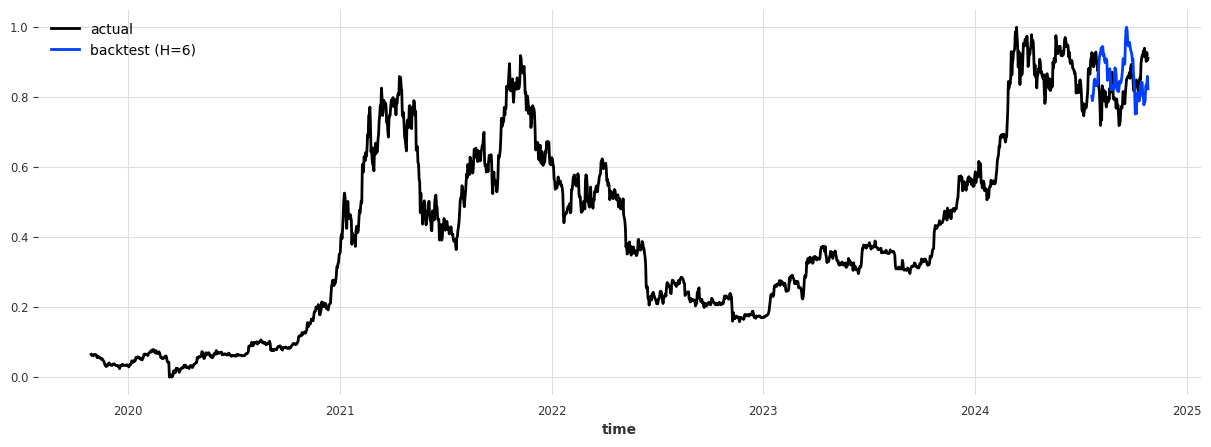

In [ ]:
plt.figure(figsize=(15, 5))
ts_scaled.plot(label="actual")
backtest.plot(label="backtest (H=6)")
df_forecat.plot(label = 'forecast')

plt.legend()
plt.show()

<Axes: >

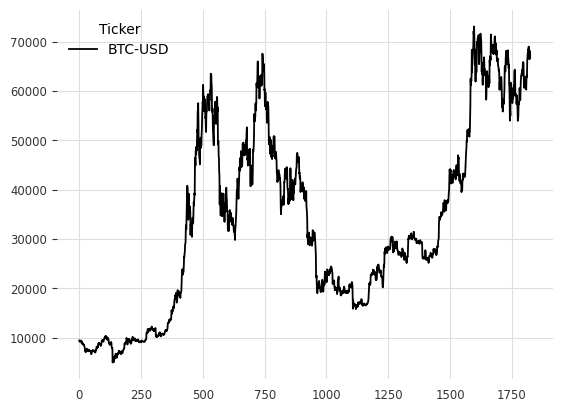

In [ ]:
btc_tidy['Close'].plot(label="actual")

# AVIR

In [ ]:
r == 0

NameError: name 'r' is not defined

In [ ]:
!pip install pytorch_lightning
!pip install darts

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import TQDMProgressBar

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

import warnings

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.CRITICAL)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [ ]:
import yfinance as yf
from datetime import date, timedelta

today = date.today()
one_year_ago = today - timedelta(days=(365*3))

btc = yf.download("AVIR", start=one_year_ago, end=today)
print(btc.info())
btc

In [ ]:
btc_tidy = btc[["Close"]].reset_index()
btc_tidy = btc_tidy.rename(columns={'Date': 'Date', 'Close': 'Close'})
btc_tidy

In [ ]:
btc_tidy['Date'] = pd.to_datetime(btc_tidy['Date']).dt.tz_localize(None)


In [ ]:
btc_tidy

In [ ]:
# prompt: conte quantos nulos tem em btc_tidy

btc_tidy.isnull().sum()

In [ ]:
btc_tidy.info()

In [ ]:
ts = TimeSeries.from_dataframe(btc_tidy, 'Date', 'Close', fill_missing_dates=True, freq='D')

In [ ]:
try:
  # Attempt to infer frequency automatically
  ts = TimeSeries.from_dataframe(btc_tidy, 'Date', 'Close', fill_missing_dates=True)
except ValueError:
  # If inference fails, specify frequency manually
  # Replace 'D' with your actual frequency (e.g., 'B' for business days, 'W' for weekly, etc.)
  ts = TimeSeries.from_dataframe(btc_tidy, 'Date', 'Close', fill_missing_dates=True, freq='D')

In [ ]:
ts

adaptando paper

In [ ]:
# Read data:
# ts = btc_tidy_array

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp("20240601"))

scaler = Scaler()

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
ts_scaled = scaler.transform(ts)

# We'll use the month as a covariate (scaling not required as one-hot-encoded)
month_series = datetime_attribute_timeseries(ts, attribute="month", one_hot=True)

In [ ]:
model_name = "TCN_air"
model_air = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=250,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
    **generate_torch_kwargs()
)

In [ ]:
model_air.fit(
    series=train_scaled,
    past_covariates=month_series,
    val_series=val_scaled,
    val_past_covariates=month_series,
)

In [ ]:
model_air = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

In [ ]:
backtest = model_air.historical_forecasts(
    series=ts_scaled,
    past_covariates=month_series,
    start=val_scaled.start_time(),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

In [ ]:
plt.figure(figsize=(15, 5))
ts_scaled.plot(label="actual")
backtest.plot(label="backtest (H=6)")

plt.legend()
plt.show()

In [ ]:
btc_tidy['Close'].plot(label="actual")

AVIR